# Understanding Hyperbole using RSA
(This tutorial written by Noah Goodman and Eli Bingham, following Kao, Wu, Bergen, and Goodman (2014).)

    "My new kettle cost a million dollars."

Hyperbole -- using an exagerated utterance to convey strong opinions -- is a common non-literal use of language. Yet non-literal uses of langauge are impossible under the simplest RSA model. Kao, et al, suggested that two ingredients could be added to ennable RSA to capture hyperbole. First, the state conveyed by the speaker and reasoned about by the listener should include affective dimensions. Second, the speaker only intends to convey information relevant to a particular topic, such as "how expensive was it?" or "how am I feeling about the price?"; pragmatic listeners hence jointly reason about this topic and the state.

In [1]:
#first some imports
import torch
torch.set_default_dtype(torch.float64)  # double precision for numerical stability

import collections
import argparse
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

In [2]:
cd "utils"

/Users/ngoodman/pplAffComp/code/utils


In [3]:
from search_inference import factor, HashingMarginal, memoize, Search

As in the simple RSA example, the inferece helper `Marginal` takes an un-normalized stochastic function, constructs the distribution over execution traces by using `Search`, and constructs the marginal distribution on return values (via `HashingMarginal`).

In [4]:
def Marginal(fn):
    return memoize(lambda *args: HashingMarginal(Search(fn).run(*args)))

The domain for this example will be states consisting of price (e.g. of a tea kettle) and the speaker's emotional arousal (whether the speaker thinks this price is irritatingly expensive). Priors here are adapted from experimental data.

In [5]:
State = collections.namedtuple("State", ["price", "arousal"])

def price_prior():
    values = [50, 51, 500, 501, 1000, 1001, 5000, 5001, 10000, 10001]
    probs = torch.tensor([0.4205, 0.3865, 0.0533, 0.0538, 0.0223, 0.0211, 0.0112, 0.0111, 0.0083, 0.0120])
    ix = pyro.sample("price", dist.Categorical(probs=probs))
    return values[ix]

def arousal_prior(price):
    probs = {
        50: 0.3173,
        51: 0.3173,
        500: 0.7920,
        501: 0.7920,
        1000: 0.8933,
        1001: 0.8933,
        5000: 0.9524,
        5001: 0.9524,
        10000: 0.9864,
        10001: 0.9864
    }
    return pyro.sample("arousal", dist.Bernoulli(probs=probs[price])).item() == 1

def state_prior():
    price = price_prior()
    state = State(price=price, arousal=arousal_prior(price))
    return state

Now we define a version of the RSA speaker that only produces *relevant* information for the literal listener. We define relevance with respect to a Question Under Discussion (QUD) -- this can be thought of as defining the speaker's current attention or topic.

The speaker is defined mathematically by:

$$P_S(u|s,q) \propto \left[ \sum_{w'} \delta_{q(w')=q(w)} P_\text{Lit}(w'|u) p(u) \right]^\alpha $$

To implement this as a probabilistic program, we start with a helper function `project`, which takes a distribution over some (discrete) domain and a function `qud` on this domain. It creates the push-forward distribution, using `Marginal` (as a Python decorator). The speaker's relevant information is then simply information about the state in this projection.

In [6]:
@Marginal
def project(dist,qud):
    v = pyro.sample("proj",dist)
    return qud_fns[qud](v)

@Marginal
def literal_listener(utterance):
    state=state_prior()
    factor("literal_meaning", 0. if meaning(utterance, state.price) else -999999.)
    return state

@Marginal
def speaker(state, qud):
    alpha = 1.
    qudValue = qud_fns[qud](state)
    with poutine.scale(scale=torch.tensor(alpha)):
        utterance = utterance_prior()
        literal_marginal = literal_listener(utterance)
        projected_literal = project(literal_marginal, qud)
        pyro.sample("listener", projected_literal, obs=qudValue)
    return utterance


The possible QUDs capture that the speaker may be attending to the price, the rough approximate price, her affect, or some combination of these. We assume a uniform QUD prior.

In [7]:
#A helper to round a number to the nearest ten:
def approx(x, b=None):
    if b is None:
        b = 10.
    div = float(x)/b
    rounded = int(div) + 1 if div - float(int(div)) >= 0.5 else int(div)
    return int(b) * rounded

#The QUD functions we consider:
qud_fns = {
    "price": lambda state: State(price=state.price, arousal=None),
    "arousal": lambda state: State(price=None, arousal=state.arousal),
    "priceArousal": lambda state: State(price=state.price, arousal=state.arousal),
    "approxPrice": lambda state: State(price=approx(state.price), arousal=None),
    "approxPriceArousal": lambda state: State(price=approx(state.price), arousal=state.arousal),
}

def qud_prior():
    values = qud_fns.keys()
    ix = pyro.sample("qud", dist.Categorical(probs=torch.ones(len(values)) / len(values)))
    return values[ix]

Now we specify the utterance meanings (standard number word denotations: "N" means exactly $N$) and an utterance prior that slightly favors multiples of ten (since they are easier to say). 

In [8]:
def utterance_cost(numberUtt):
    preciseNumberCost = 1.
    return 0. if approx(numberUtt) == numberUtt else preciseNumberCost

def utterance_prior():
    utterances = [50, 51, 500, 501, 1000, 1001, 5000, 5001, 10000, 10001]
    utteranceLogits = -torch.tensor(list(map(utterance_cost, utterances)),
                                    dtype=torch.float64)
    ix = pyro.sample("utterance", dist.Categorical(logits=utteranceLogits))
    return utterances[ix]

def meaning(utterance, price):
    return utterance == price

OK, let's see what number term this speaker will say to express different states and QUDs.

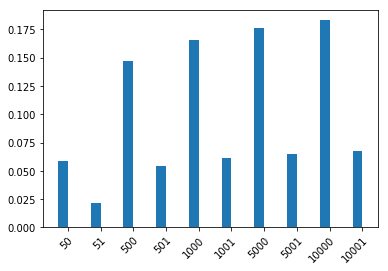

In [9]:
#silly plotting helper:
def plot_dist(d):
    support = d.enumerate_support()
    data = [d.log_prob(s).exp().item() for s in d.enumerate_support()]
    names = support

    ax = plt.subplot(111)
    width=0.3
    bins = map(lambda x: x-width/2,range(1,len(data)+1))
    ax.bar(bins,data,width=width)
    ax.set_xticks(map(lambda x: x, range(1,len(data)+1)))
    ax.set_xticklabels(names,rotation=45, rotation_mode="anchor", ha="right")


plot_dist( speaker(State(price=51, arousal=True), "arousal") )

Try different values above! When will the speaker favor non-literal utterances?

Finally, the pragmatic listener doesn't know what the QUD is and so jointly reasons abut this and the state.

In [10]:
@Marginal
def pragmatic_listener(utterance):
    state = state_prior()
    qud = qud_prior()
    speaker_marginal = speaker(state, qud)
    pyro.sample("speaker", speaker_marginal, obs=utterance)
    return state

How does this listener interpret the uttered price "10,000"? On the one hand this is a very unlikely price *a priori*, on the other if it were true it would come with strong arousal. Altogether this becomes a plausible *hyperbolic* utterence:

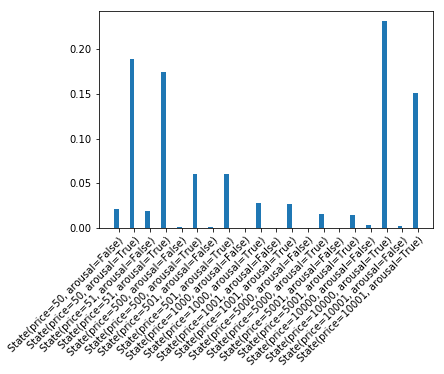

In [12]:
plot_dist( pragmatic_listener(10000) )

# Irony and More Complex Affect